# Autor
Danilo César Tertuliano Melo - 221031149

Github: DaniloCTM

------
# Objetivo

O objetivo deste artigo é treinar um modelo para identificar a diferença entre helicopteros e aviões. Além disso, o modelo foi publicado no hugginFace.

------
# Passo 1 - Configurando o Ambiente

Começamos instalando as bibliotecas necessárias para o projeto

In [ ]:
!pip install duckduckgo_search

In [2]:
from fastai.vision.all import *
from fastdownload import download_url


from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Em seguida realizamos o download das imagens usando a API do Duckduckgo

In [3]:
searches = 'helicopter','airplane'
path = Path('airplane_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'helicopter photo'
Searching for 'helicopter sun photo'
Searching for 'helicopter shade photo'
Searching for 'airplane photo'
Searching for 'airplane sun photo'
Searching for 'airplane shade photo'


-----

# Passo 2 - Organizando os Dados
Agora com os dados já baixados preparamos eles e verificamos se existe algum problema nas imagens

In [4]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

-----
# Passo 3 - Treinando o Modelo

Primeiro, criamos os conjuntos de dados por meio da função DataBlock(), onde definimos:

* O formato de entrada e saída dos dados
* O tamanho do conjunto de validação e treinamento
* O tamanho das imagens passadas para o modelo

Em seguida, exibimos uma batch com alguns dos dados.

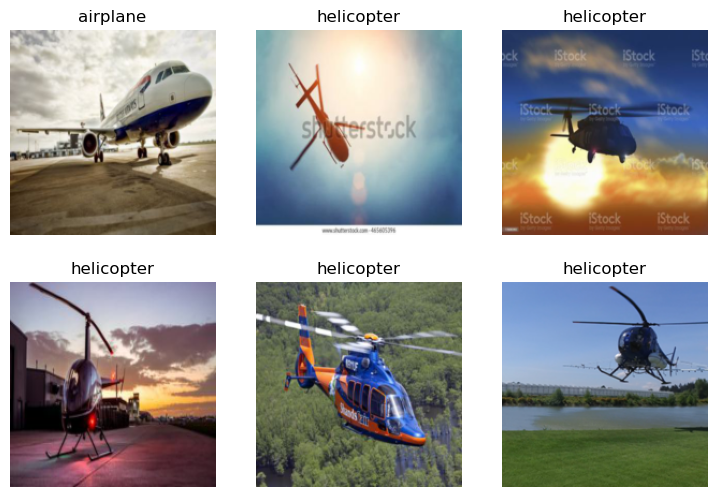

In [5]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Agora é realizado a criação da rede neural e em seguida utilizamos a função fine_tune para ajustar os pesos

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/model

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.989589,0.935148,0.333333,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.458406,0.403941,0.151515,00:21
1,0.369467,0.283324,0.090909,00:21
2,0.269299,0.242356,0.060606,00:22


-------
# Passo 4 - Testando o Modelo

Nessa etapa realizamos o teste do modelo ainda no kaggle

This is a: airplane.
Probability it's a airplane: 0.9999


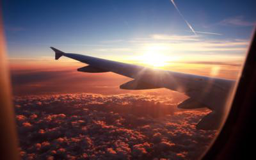

In [13]:
dest = '/kaggle/working/airplane_or_not/airplane/7112cfa0-7d18-493d-93dd-5d16f3dce841.jpg'
is_airplane,_,probs = learn.predict(PILImage.create(dest))
print(f"This is a: {is_airplane}.")
print(f"Probability it's a airplane: {probs[0]:.4f}")
im = Image.open(dest)
im.to_thumb(256,256)

----
# Passo 5 - Fazendo Deploy do Modelo

Com o modelo treinado e testado localmente exportamos o modelo para usar no hugging Face

In [ ]:
learn.export('model.pkl')

Com tudo configurado no Hugging Face o modelo fica disponível no seguinte link:

https://huggingface.co/spaces/DaniloTertu/lesson-2

# Conclusão

Durante essa lição foi possível verificar que após o modelo ser treinado ele pode ser exportado para funcionar em outros ambientes sem precisar passar pela etapa de treinamento novamente. Além disso, foi possível revisar os conceitos da primeira lição